In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "mips64el/"
files = os.listdir(path)
len(files)

8625

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [4]:
def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [6]:
sample_code_dict = extract_code(path, sample_files)
len(sample_code_dict.keys())

100

In [7]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

b379763fb420d893049fd0ad9372e306	196832	[240, 255, 189, 103, 0, 0, 188, 255, 5, 0]
62cab46d5e9f3d16bda08d03aeffd3eb	112032	[240, 255, 189, 103, 0, 0, 188, 255, 3, 0]
10edf5d70847fdc7ff63203945054f12	38416	[32, 253, 189, 103, 208, 2, 188, 255, 2, 0]
a92c3a37fce46b059eb2774e957657d3	11040	[144, 255, 189, 103, 88, 0, 188, 255, 2, 0]
d557caef441e787cb66328bd3ec1f6e5	28576	[240, 255, 189, 103, 0, 0, 188, 255, 2, 0]
dfe69694543568a9fa2320a370c7a5d0	19760	[144, 255, 189, 103, 88, 0, 188, 255, 2, 0]
6c469d9bd7d2d22b5a11be1c97356bc7	16112	[160, 247, 189, 103, 72, 8, 188, 255, 2, 0]
e52359842fd32e5782af291bb8426dd1	17728	[192, 254, 189, 103, 40, 1, 188, 255, 2, 0]
34cc63a87a002003f54c3b2f0c6c8438	20368	[240, 255, 189, 103, 0, 0, 188, 255, 2, 0]
442b39a6c5451ea53ecc819dcb2fafc3	11312	[80, 255, 189, 103, 160, 0, 188, 255, 2, 0]
7632623bf7bd87c6d666482c71194fb9	10928	[240, 253, 189, 103, 0, 2, 188, 255, 2, 0]
17bcc8e3e59ae8b14ea89428d5353c57	53440	[224, 255, 189, 103, 16, 0, 188, 255, 3, 0]
6e4e351

In [8]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

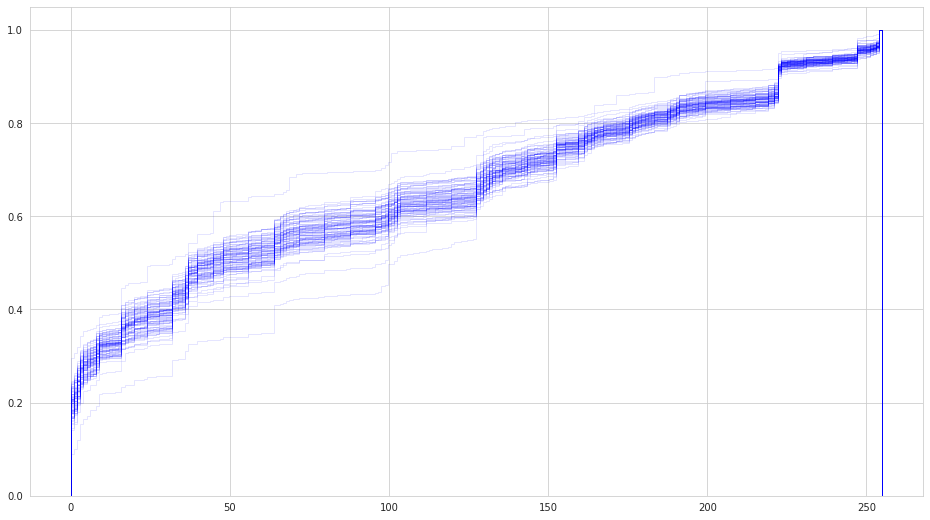

In [9]:
plot_dists(sample_code_dict)

In [10]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [11]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [12]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:39<00:00, 25.37it/s]


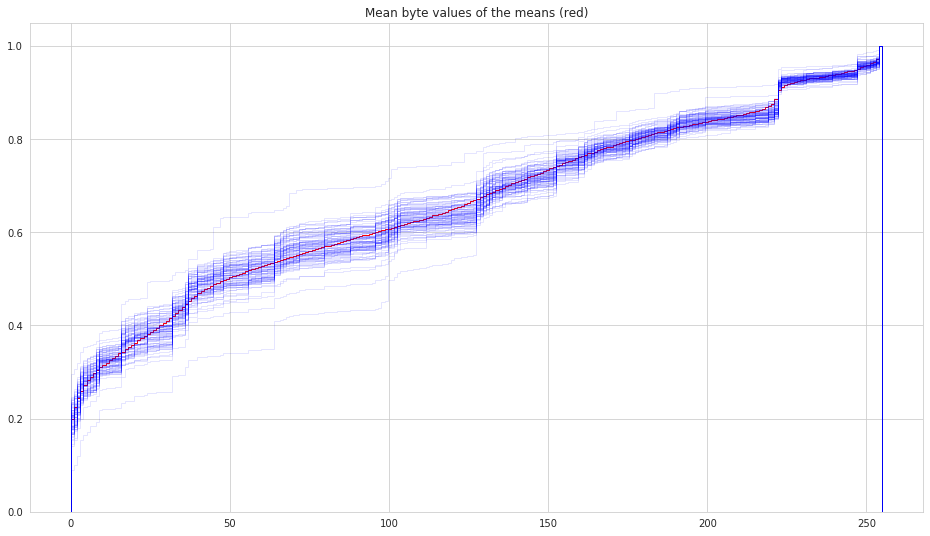

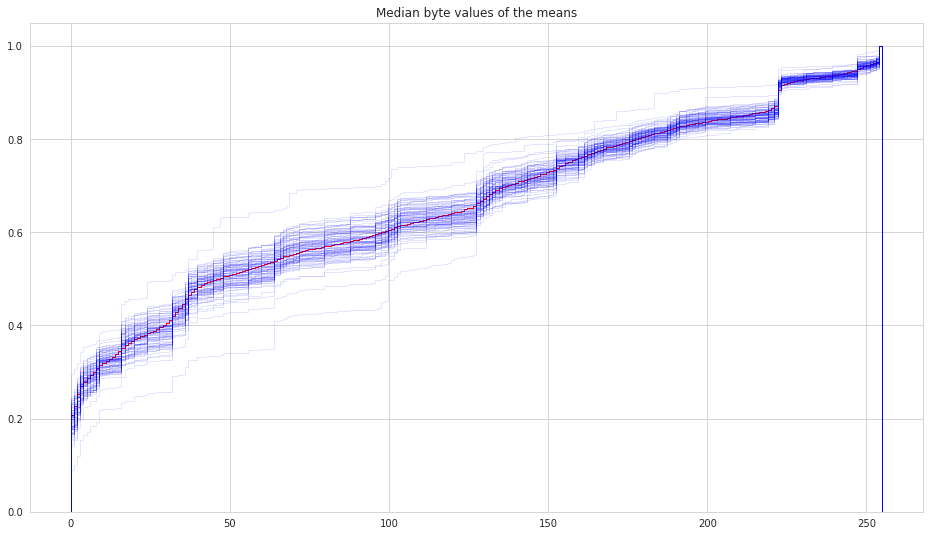

In [13]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

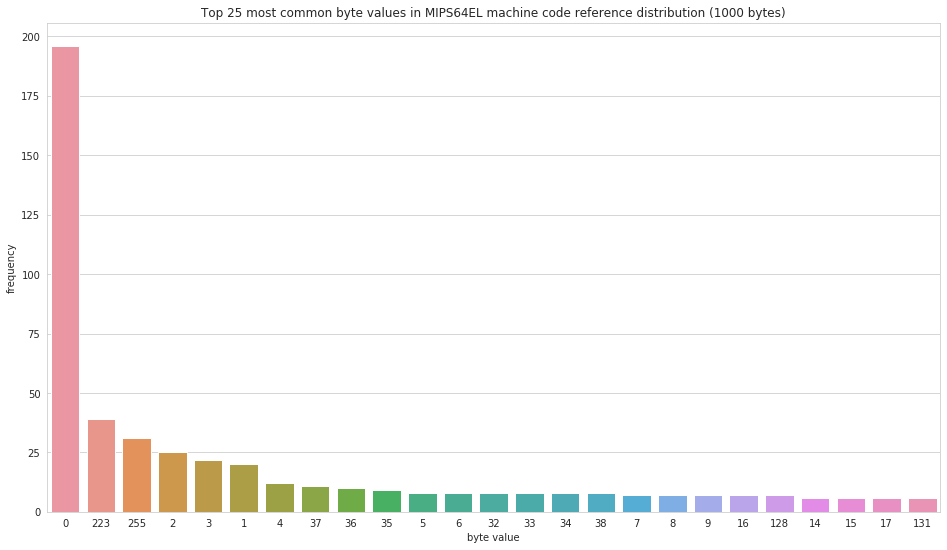

In [14]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in MIPS64EL machine code reference distribution (1000 bytes)")
plt.show()

In [15]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xdf',
 '0xff',
 '0x2',
 '0x3',
 '0x1',
 '0x4',
 '0x25',
 '0x24',
 '0x23',
 '0x5',
 '0x6',
 '0x20',
 '0x21',
 '0x22',
 '0x26',
 '0x7',
 '0x8',
 '0x9',
 '0x10',
 '0x80',
 '0xe',
 '0xf',
 '0x11',
 '0x83']

In [16]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [17]:
len(test_files)

3000

In [18]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [19]:
test_code_dict = extract_code(path, test_files, n_files=3000)

for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

fff9c59a26b51c0684bbef3dcd75c1ca	25760	[224, 255, 189, 103, 16, 0, 188, 255, 2, 0]
268dde4b3710bbb1640b5f46745e60ea	38736	[80, 255, 189, 103, 152, 0, 188, 255, 2, 0]
7960eb9e741842b97c6d68e8550b6990	31936	[240, 255, 189, 103, 0, 0, 188, 255, 2, 0]
628e38e25530f9e090338a57295fa56d	149632	[240, 255, 189, 103, 0, 0, 188, 255, 5, 0]
3ac5dca293ce602654bc9861002b18c8	18880	[128, 255, 189, 103, 104, 0, 188, 255, 2, 0]
a7f389bf2fd4cb83a17bbd527e5764d7	86944	[144, 255, 189, 103, 96, 0, 188, 255, 3, 0]
67479b9d5e76e8023375578975a66fc6	32432	[16, 128, 189, 103, 80, 144, 3, 52, 1, 0]
e28391a6f0bf0dd9b2882a04eea8eaa5	224816	[96, 255, 189, 103, 136, 0, 188, 255, 6, 0]
602524f88636d17c05728b6d087bc77a	23424	[16, 253, 189, 103, 216, 2, 188, 255, 2, 0]
07a2a9e13d9d7b098d7a2ac2cf76d7c1	85248	[208, 255, 189, 103, 32, 0, 188, 255, 3, 0]
64060b2c77ed056e0de76b00b623acfb	10128	[224, 255, 189, 103, 16, 0, 188, 255, 2, 0]
df1190d1ba4c15f07c04db4c09f2a298	23744	[48, 243, 189, 103, 152, 12, 188, 255, 2, 0]
e78c

In [20]:
len(test_code_dict.keys())

895

In [21]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(895, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
fff9c59a26b51c0684bbef3dcd75c1ca,25760,3.08802,0.344222,88.1691,60,86.4075
268dde4b3710bbb1640b5f46745e60ea,38736,3.58192,0.378514,89.1117,48,88.4132
7960eb9e741842b97c6d68e8550b6990,31936,1.63163,0.178146,84.8252,45,87.0361
628e38e25530f9e090338a57295fa56d,149632,3.27874,0.322039,88.4202,56,88.8603
3ac5dca293ce602654bc9861002b18c8,18880,2.90512,0.306775,83.8548,45,84.4469
...,...,...,...,...,...,...
31e143bf1c43443554f11dffe95b5298,435936,4.19901,0.454715,89.0118,64,85.8973
7636385ba36c00fff10ee499c25c6ed6,765168,1.9754,0.233462,86.2984,56,85.7116
c9b00214a66ff2f8086006b11a529064,54512,3.32497,0.351872,86.2244,59,84.5507
a48fc6fad4cf9157e26140c7d3905e92,34560,6.9696,0.72903,79.2148,37,87.1692


In [22]:
test_results_df.mean()

size                    359153.796648
wasserstein distance         4.353514
energy distance              0.461605
mean                        85.834029
median                      49.260335
standard deviation          86.822404
dtype: float64

In [23]:
test_results_df.median()

size                    59072.000000
wasserstein distance        3.719595
energy distance             0.399233
mean                       86.485284
median                     48.000000
standard deviation         86.854561
dtype: float64

In [24]:
test_results_df["size"].sum()

321442648

In [25]:
test_results_df["siff9c9bd0e346598abb5a19025534901b.code.xzze"].sum() / 1000000

321.442648

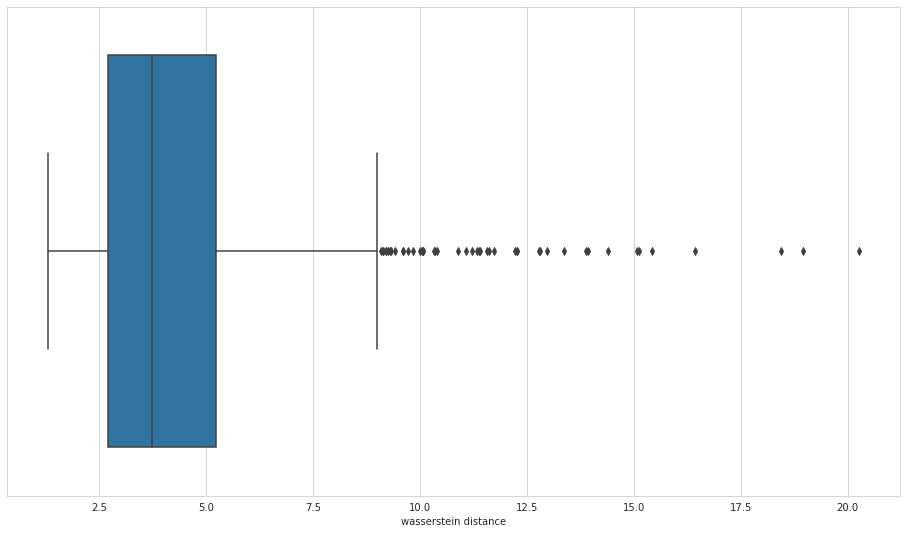

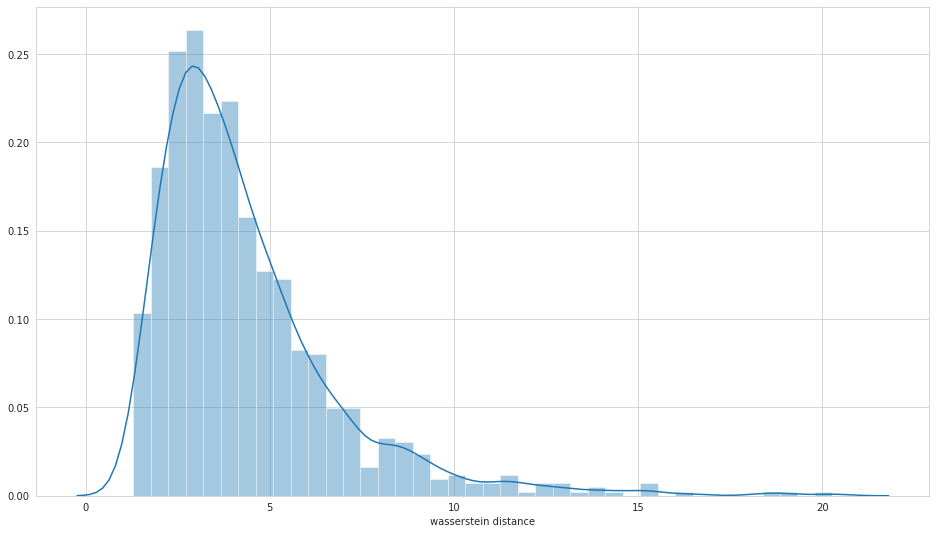

In [26]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

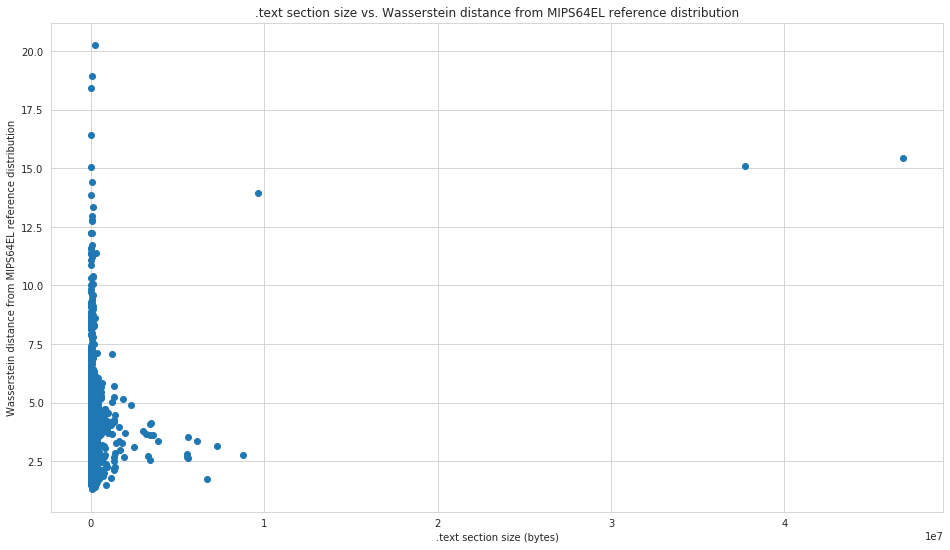

In [27]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from MIPS64EL reference distribution")
plt.title(".text section size vs. Wasserstein distance from MIPS64EL reference distribution")
plt.show()

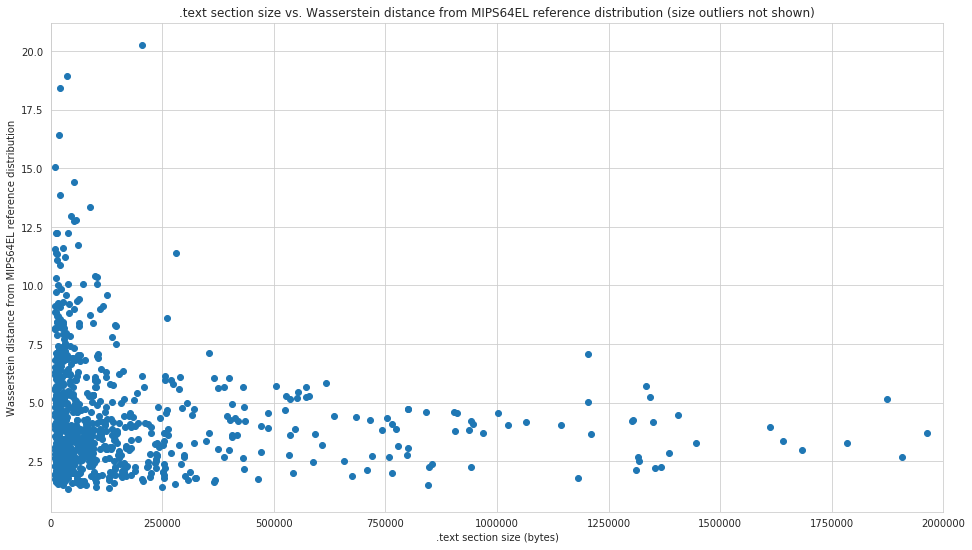

In [34]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from MIPS64EL reference distribution")
plt.title(".text section size vs. Wasserstein distance from MIPS64EL reference distribution (size outliers not shown)")
plt.xlim(0, 2000000)
plt.show()

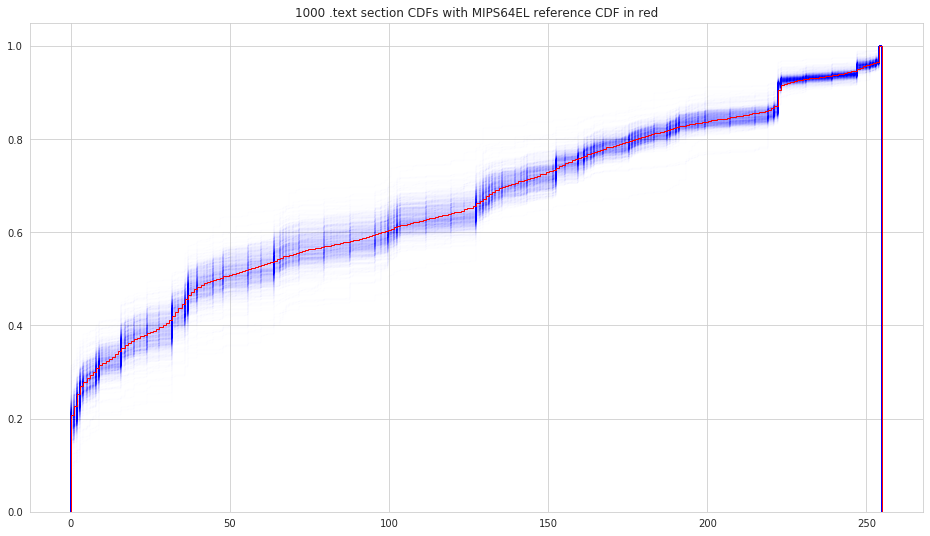

In [29]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with MIPS64EL reference CDF in red")
plt.show()

In [30]:
# export reference distribution
with open("MIPS64EL_reference", "wb") as f:
    pickle.dump(median, f)